This notebook shows a simple approach to calculating a zonal average from data on unstructured grids. 

The basic approach is to bin the data based on the *cell center* latitude (or longitude for meridional mean). The code here also provides the option of specifiying weights, which are mostly likely provided by the `area` variable that is usually included in unstructured grid output from climate models. The approach works fine for regular grids, too, but they will need to be "flattened" and the latitude or longitude and area arrays will need to be broadcast to match the data shape and flattened in the same way. 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


def binned_average(data, bin_data, bin_width, bin_start, bin_end, weights=None):
    """
    Generalized binned average function. Returns `data` averaged within
    bins of `bin_data`.

    data : xr.DataArray
        the DataArray to be averaged.

    bin_data : xr.DataArray or np.ndarray
        determines the binning
        Expected to be one-dimensional (ncol),
        and be same size as one of the dimensions of data.
    
    bin_width: float
        width of bins in units that match bin_data

    bin_start: float
        starting value for the bins

    bin_end: float
        ending value of the bins

    weights: xr.DataArray
        weighting to apply, must be same shape as data
    """
    if weights is not None:
        assert weights.shape == data.shape, 'Weights must be same shape as data'
    else:
        weights = xr.DataArray(np.ones(data.shape), dims=data.dims, coords=data.coords)

    # Create bins
    bins = np.arange(bin_start, bin_end+bin_width, bin_width)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Assign each value of `bin_data` to a bin
    bin_indices = np.digitize(bin_data, bins) - 1

    n_bins = len(bins) - 1 # number of bins (== len(bin_centers))

    # Create a mask for each bin
    mask = np.zeros((len(bin_data), n_bins))
    mask[np.arange(len(bin_data)), bin_indices] = 1
        
    # Identify the binned dimension in data
    binned_dim = [dim for dim in data.dims if data[dim].size == bin_data.size][0]

    # Compute the weighted sum for eacn bin
    weighted_sum = (data * weights).dot(xr.DataArray(mask, dims=[binned_dim, 'bins']))
    # Compute the sum of weights for each bin
    weight_sum = weights.dot(xr.DataArray(mask, dims=[binned_dim, 'bins']))
    # Compute average
    result = weighted_sum / weight_sum
    # Replace inf and nan with np.nan
    result = result.where(np.isfinite(result), np.nan)
    # Set coordinates for the bins
    result = result.assign_coords(bins=bin_centers)
    
    # Add attributes if possible
    if hasattr(bin_data, 'name'):
        add_str = f'by {bin_data.name}'
    else:
        add_str = ''
    result.attrs['long_name'] = f'{data.name} binned {add_str}'
    result.attrs['units'] = data.attrs.get('units', '')
    result.bins.attrs['units'] = bin_data.attrs.get('units', '')
    result.bins.attrs['long_name'] = 'bins'
    
    return result 


def lon_binned_average(data, lon, bin_width=10, weights=None):
    """Example application of binned average. This is the 'meridional average'
       that bins values of longitude. This is used, for example, to visualize
       the SST gradient across the Pacific Ocean, which differs depending on
       the phase of the ENSO cycle. 
    """
    # Ensure data and lon are xarray DataArrays
    if not isinstance(data, xr.DataArray):
        raise TypeError("data must be an xarray DataArray")
    if not isinstance(lon, xr.DataArray):
        raise TypeError("lon must be an xarray DataArray")
    
    # Ensure longitudes are in the range [0, 360)
    lon_values = lon.values % 360

    # Create bins
    bin_range = (0, 360)

    result = binned_average(data, lon, bin_width, bin_range[0], bin_range[1], weights=weights)
    return result 


def zonal_average(data, lat, bin_width=10, weights=None):
    """Example application of binned average. 
       This is the 'zonal average'
       that bins values of latitude.
    """
    # Ensure data and lon are xarray DataArrays
    if not isinstance(data, xr.DataArray):
        raise TypeError("data must be an xarray DataArray")
    if not isinstance(lat, xr.DataArray):
        raise TypeError("lat must be an xarray DataArray")

    # Ensure longitudes are in the range [-90, 90)
    # otherwise add an extra bin
    if lat.max().item() >= 90:
        bin_range = (-90, 90+(0.5*bin_width)) # if values are at edges then digitize gives extra value
    else:
        bin_range = (-90, 90)


    result = binned_average(data, lat, bin_width, bin_range[0], bin_range[1], weights=weights)
    return result 

In [3]:
# example data
# E3SM output on the cubed sphere mesh
ds = xr.open_dataset("/Volumes/Samsung_T5/E3SM_abrupt4xCO2/20180215.DECKv1b_abrupt4xCO2.ne30_oEC.edison.cam.h0.TS.ncrcat.nc")
# Data note: this dataset has a lot of times, too.

data = ds['TS']
area = ds['area']
lat = ds['lat']


In [4]:
bw = 2.5
zm_data = zonal_average(data, lat, bin_width=bw)
zm_data

<xarray.DataArray (time: 1788, bins: 73)> Size: 1MB
array([[250.49120222, 255.25453595, 259.35782002, ..., 243.52923965,
        243.43877029, 243.18240356],
       [237.26108297, 241.9565427 , 246.87588628, ..., 243.90404156,
        244.17850723, 243.93063354],
       [223.75667245, 229.32842418, 234.54876497, ..., 243.17312568,
        242.92751312, 242.7978363 ],
       ...,
       [241.25720215, 244.65318707, 247.68285638, ..., 282.31476266,
        281.95729675, 281.79516602],
       [249.47189404, 252.65896715, 255.86550988, ..., 280.57150705,
        280.35301666, 280.28189087],
       [261.11227998, 263.288711  , 265.80072007, ..., 279.24875641,
        279.19306183, 279.17388916]])
Coordinates:
  * time     (time) object 14kB 0001-02-01 00:00:00 ... 0150-01-01 00:00:00
  * bins     (bins) float64 584B -88.75 -86.25 -83.75 ... 86.25 88.75 91.25
Attributes:
    long_name:  TS binned by lat
    units:      K

(-90.0, 90.0)

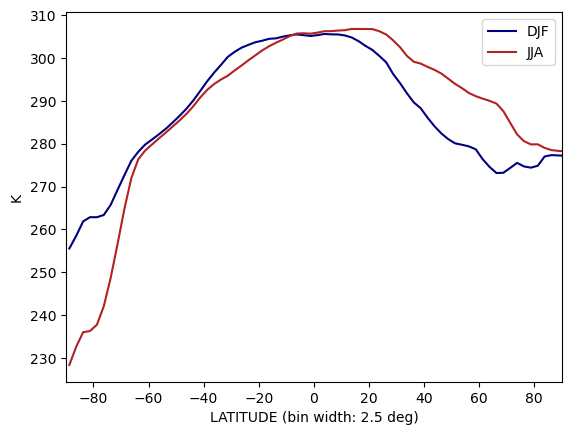

In [5]:
djf_mean = zm_data.sel(time=zm_data.time.dt.month.isin([1,2,12])).mean(dim='time')
jja_mean = zm_data.sel(time=zm_data.time.dt.month.isin([6,7,8])).mean(dim='time')

fig, ax = plt.subplots()
ax.plot(djf_mean.bins, djf_mean, color='navy', label='DJF')
ax.plot(jja_mean.bins, jja_mean, color='firebrick', label='JJA')
ax.legend()
ax.set_ylabel(getattr(data, 'units', 'N/A'))
ax.set_xlabel(f"LATITUDE (bin width: {bw} deg)")
ax.set_xlim([-90, 90])


In [6]:
# include the area weighting
wzm_data = zonal_average(data, lat, bin_width=bw, weights=area.broadcast_like(data))
wzm_data

<xarray.DataArray (time: 1788, bins: 73)> Size: 1MB
array([[250.74763409, 255.37477499, 259.30314021, ..., 243.52703888,
        243.45066167, 243.18240356],
       [237.4804988 , 242.0545361 , 246.81760089, ..., 243.9077708 ,
        244.17904332, 243.93063354],
       [224.00571166, 229.4302679 , 234.49882245, ..., 243.18932175,
        242.93092861, 242.7978363 ],
       ...,
       [241.41094252, 244.7201132 , 247.69527501, ..., 282.31148956,
        281.97448645, 281.79516602],
       [249.54016006, 252.71240654, 255.8476799 , ..., 280.57448988,
        280.36735438, 280.28189087],
       [261.18713165, 263.35662996, 265.80327071, ..., 279.25791519,
        279.20198714, 279.17388916]])
Coordinates:
  * time     (time) object 14kB 0001-02-01 00:00:00 ... 0150-01-01 00:00:00
  * bins     (bins) float64 584B -88.75 -86.25 -83.75 ... 86.25 88.75 91.25
Attributes:
    long_name:  TS binned by lat
    units:      K

Text(0.5, 1.0, 'E3SM Example')

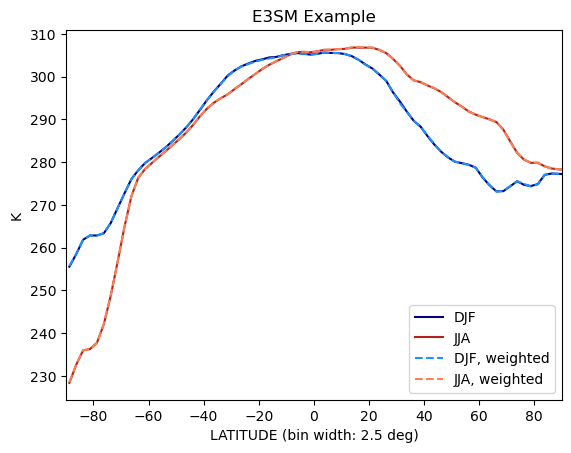

In [7]:
djf_wmean = wzm_data.sel(time=wzm_data.time.dt.month.isin([1,2,12])).mean(dim='time')
jja_wmean = wzm_data.sel(time=wzm_data.time.dt.month.isin([6,7,8])).mean(dim='time')

fig, ax = plt.subplots()
ax.plot(djf_mean.bins, djf_mean, color='navy', label='DJF')
ax.plot(jja_mean.bins, jja_mean, color='firebrick', label='JJA')
ax.plot(djf_wmean.bins, djf_wmean, color='dodgerblue', linestyle='dashed', label='DJF, weighted')
ax.plot(jja_wmean.bins, jja_wmean, color='coral', linestyle='dashed', label='JJA, weighted')
ax.legend()
ax.set_ylabel(getattr(data, 'units', 'N/A'))
ax.set_xlabel(f"LATITUDE (bin width: {bw} deg)")
ax.set_xlim([-90, 90])
ax.set_title("E3SM Example")


In [8]:
# Add an MPAS example
mpas_ds = xr.open_dataset("/Users/brianpm/Desktop/amip_a240.cam.h0.1981-05.nc")
mpas_data = mpas_ds['TS'].squeeze()
mpas_lat = mpas_ds['lat'].squeeze()
mpas_area = mpas_ds['area']
# dataset note: this example is a single monthly average

In [9]:
bw = 2.5
mpas_zm = zonal_average(mpas_data, mpas_lat, bin_width=bw)
mpas_wzm = zonal_average(mpas_data, mpas_lat, bin_width=bw, weights=mpas_area)


Text(0.5, 1.0, 'MPAS (240km) Example')

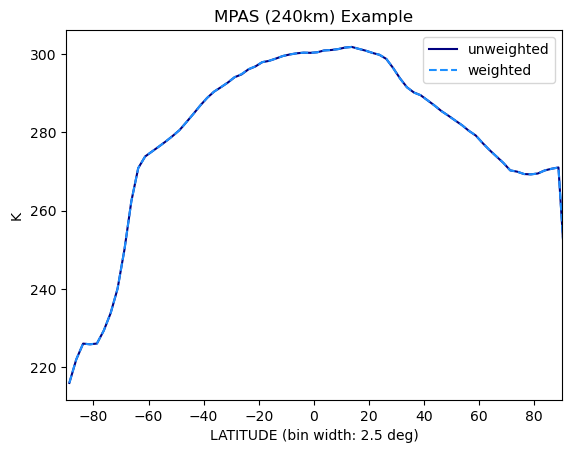

In [10]:
fig, ax = plt.subplots()
ax.plot(mpas_zm.bins, mpas_zm, color='navy', label='unweighted')
ax.plot(mpas_wzm.bins, mpas_wzm, color='dodgerblue', linestyle='dashed', label='weighted')
ax.legend()
ax.set_ylabel(getattr(mpas_data, 'units', 'N/A'))
ax.set_xlabel(f"LATITUDE (bin width: {bw} deg)")
ax.set_xlim([-90, 90])
ax.set_title("MPAS (240km) Example")


Original array:
<xarray.DataArray 'area' (ncol: 10242)> Size: 82kB
[10242 values with dtype=float64]
Dimensions without coordinates: ncol
Attributes:
    long_name:  physics column areas

Altered array:
<xarray.DataArray 'area' (ncol: 10242)> Size: 82kB
[10242 values with dtype=float64]
Dimensions without coordinates: ncol
Attributes:
    long_name:  physics column areas

Number of elements changed: 5116
Percentage of elements changed: 49.95%


Text(0.5, 1.0, 'MPAS (240km) Example')

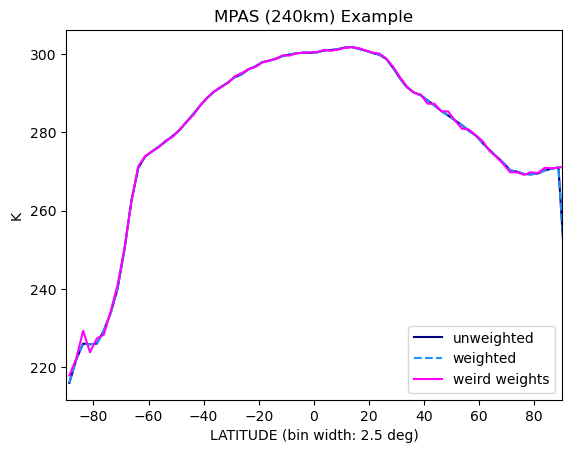

In [15]:

# Create a copy of the original array
mpas_area_altered = mpas_area.copy()

# Generate a boolean mask for 50% of the elements
mask = np.random.choice([True, False], size=mpas_area.shape, p=[0.5, 0.5])

# Double the selected elements
mpas_area_altered[mask] *= 1e6

# Print some information to verify the changes
print("Original array:")
print(mpas_area)
print("\nAltered array:")
print(mpas_area_altered)
print(f"\nNumber of elements changed: {np.sum(mask)}")
print(f"Percentage of elements changed: {np.mean(mask)*100:.2f}%")

mpas_wzm2 = zonal_average(mpas_data, mpas_lat, bin_width=bw, weights=mpas_area_altered)

fig, ax = plt.subplots()
ax.plot(mpas_zm.bins, mpas_zm, color='navy', label='unweighted')
ax.plot(mpas_wzm.bins, mpas_wzm, color='dodgerblue', linestyle='dashed', label='weighted')
ax.plot(mpas_wzm2.bins, mpas_wzm2, color='magenta', label='weird weights')
ax.legend()
ax.set_ylabel(getattr(mpas_data, 'units', 'N/A'))
ax.set_xlabel(f"LATITUDE (bin width: {bw} deg)")
ax.set_xlim([-90, 90])
ax.set_title("MPAS (240km) Example")

 

In [28]:
# try a regionally refined grid
rr_ds = xr.open_dataset("/Users/brianpm/Desktop/qpc6_trbelt_cam7l93_01.cam.h2a.0001-04-05-21600.nc")
rr_lat = rr_ds['lat']
rr_area = rr_ds['area']
rr_data = rr_ds['TS']
rr_wzm = zonal_average(rr_data, rr_lat, bin_width=bw, weights=rr_area.broadcast_like(rr_data))

# analytical expression used for TS in aquaplanet:
latvals = np.radians(rr_wzm.bins)
qobs = 0.5*((27*(1 - np.sin(3*latvals/2)**2))+(27*(1 - np.sin(3*latvals/2)**4)))
qobs = np.where(np.absolute(latvals) < np.pi/3, qobs, 0)
# transform to K
qobs += 273.15
fig, ax = plt.subplots()
ax.plot(rr_wzm.bins, rr_wzm[0,:], label='averaged')
ax.plot(rr_wzm.bins, qobs, marker='x', linestyle='none', label='Analytic')
ax.legend()
ax.set_title("Aquaplanet Qobs SST")



Text(0.5, 1.0, 'Aquaplanet Qobs SST')

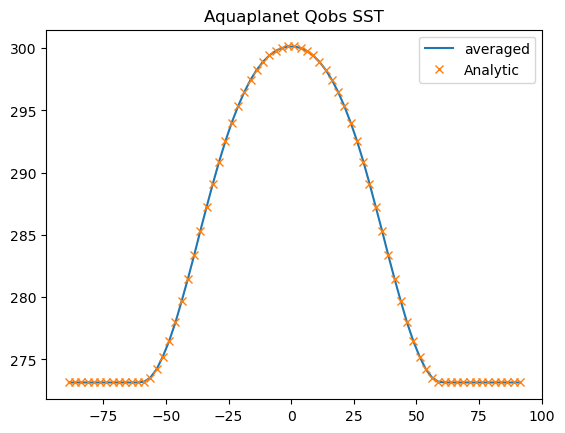